In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, pearsonr
import scprep
import torch
import pandas as pd
import scanpy
import sys
sys.path.append('..')
from utils import sinkhorn_knopp_unbalanced

In [17]:
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, ranksums, ttest_ind

In [4]:
def load_data_full(datafile):
    dat = np.load(datafile)
    return dat['pca'][:, :10], dat['sample_labels']

def get_transform_matrix(gamma, a, epsilon=1e-8):
    """Return matrix such that T @ a = b
    gamma : gamma @ 1 = a; gamma^T @ 1 = b
    """
    return (np.diag(1.0 / (a + epsilon)) @ gamma).T

def get_growth_coeffs(gamma, a, epsilon=1e-8, normalize=False):
    T = get_transform_matrix(gamma, a, epsilon)
    unnormalized_coeffs = np.sum(T, axis=0)
    if not normalize:
        return unnormalized_coeffs
    return unnormalized_coeffs / np.sum(unnormalized_coeffs) * len(unnormalized_coeffs)

In [5]:
def get_all_growth_coeffs(alpha):
    gcs = []
    for i in range(len(dfs) - 1):
        a, b = dfs[i], dfs[i + 1]
        m, n = a.shape[0], b.shape[0]
        M = cdist(a, b)
        entropy_reg = 0.1
        reg_1, reg_2 = alpha, 10000
        gamma = sinkhorn_knopp_unbalanced(
            np.ones(m) / m, np.ones(n) / n, M, entropy_reg, reg_1, reg_2
        )
        gc = get_growth_coeffs(gamma, np.ones(m) / m)
        gcs.append(gc)
    return gcs

In [6]:
for alpha in [0.01, 0.1, 1, 5, 10]:
    print (alpha)
    data, labels = load_data_full('data/combined_magic_pca_tnet_input_5_tp.npz')
    
    # Compute couplings
    timepoints = np.unique(labels)
    dfs = [data[labels == tp] for tp in timepoints]
    
    gcs = get_all_growth_coeffs(alpha)
    gcs = np.concatenate(gcs)
    print(gcs.shape)
    np.save(f'gcs_5tp_{alpha}.npy', gcs)
    
    data, labels = load_data_full('data/combined_magic_pca_tnet_input_5_tp_leave_out_45.npz')
    
    # Compute couplings
    timepoints = np.unique(labels)
    dfs = [data[labels == tp] for tp in timepoints]
    
    gcs = get_all_growth_coeffs(alpha)
    gcs = np.concatenate(gcs)
    print(gcs.shape)
    np.save(f'gcs_5tp_leave_out_45_{alpha}.npy', gcs)
    
    data, labels = load_data_full('data/combined_magic_pca_tnet_input_5_tp_leave_out_5.npz')
    
    # Compute couplings
    timepoints = np.unique(labels)
    dfs = [data[labels == tp] for tp in timepoints]
    
    gcs = get_all_growth_coeffs(alpha)
    gcs = np.concatenate(gcs)
    print(gcs.shape)
    np.save(f'gcs_5tp_leave_out_5_{alpha}.npy', gcs)

0.01



KeyboardInterrupt



## Growth coefficients

In [4]:
combined_magic_pc_norm = np.load('data/combined_magic_pca_tnet_input_5_tp.npz')['pca']
refined_clust = np.load('data/combined_magic_pca_tnet_input_5_tp.npz')['sample_labels']

In [5]:
adata_beta = scanpy.read_h5ad('../data/beta_run_2.h5ad')

In [6]:
wt_latent_coords = np.load('../analysis_archetypes/results/WT_latent_coords_7_ats.npy')
wt_latent = np.load('../analysis_archetypes/results/WT_latent_coords_7_ats.npy')
adata_beta_wt = adata_beta[adata_beta.obs['samples'] == 'WT']
at_dist = []
for row in wt_latent:
    id = np.argwhere(row > 0.5)
    if len(id) == 1:
        at_dist.append('WT AT ' + str(id[0][0]+1))
        
    else:
        at_dist.append('Uncommitted')
        
wt_at_comms = pd.Series(at_dist, index = adata_beta_wt.obs_names)

hfd_latent = np.load('../analysis_archetypes/results/HFD_latent_coords_4_ats.npy')
adata_beta_hfd = adata_beta[adata_beta.obs['samples'] == 'HFD']
at_dist = []
for row in hfd_latent:
    id = np.argwhere(row > 0.5)
    if len(id) == 1:
        at_dist.append('HFD AT ' + str(id[0][0]+1))
        
    else:
        at_dist.append('Uncommitted')
        
hfd_at_comms = pd.Series(at_dist, index = adata_beta_hfd.obs_names)

obob_latent = np.load('../analysis_archetypes/results/OB_OB_latent_coords_3_ats.npy')
adata_beta_obob = adata_beta[adata_beta.obs['samples'] == 'OB/OB']
at_dist = []
for row in obob_latent:
    id = np.argwhere(row > 0.5)
    if len(id) == 1:
        at_dist.append('OB/OB AT ' + str(id[0][0]+1))
        
    else:
        at_dist.append('Uncommitted')
        
obob_at_comms = pd.Series(at_dist, index = adata_beta_obob.obs_names)

/tmp/ipykernel_3267167/2151621306.py:5: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


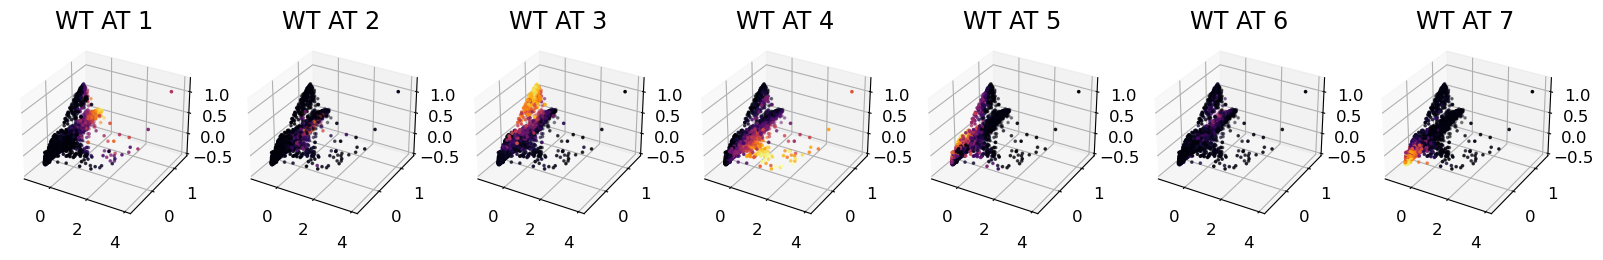

In [17]:
fig = plt.figure(figsize=(20,7))
for i in range(7):
    ax = fig.add_subplot(1,7,i+1, projection='3d')
    scprep.plot.scatter3d(combined_magic_pc_norm[adata_beta.obs.samples == 'WT'], c=wt_latent[:, i], title=f'WT AT {i+1}', ax=ax, colorbar=False)
plt.tight_layout()

fig.savefig('figures/WT_archetypal_distribution_on_combined_embedding.png', dpi=200)

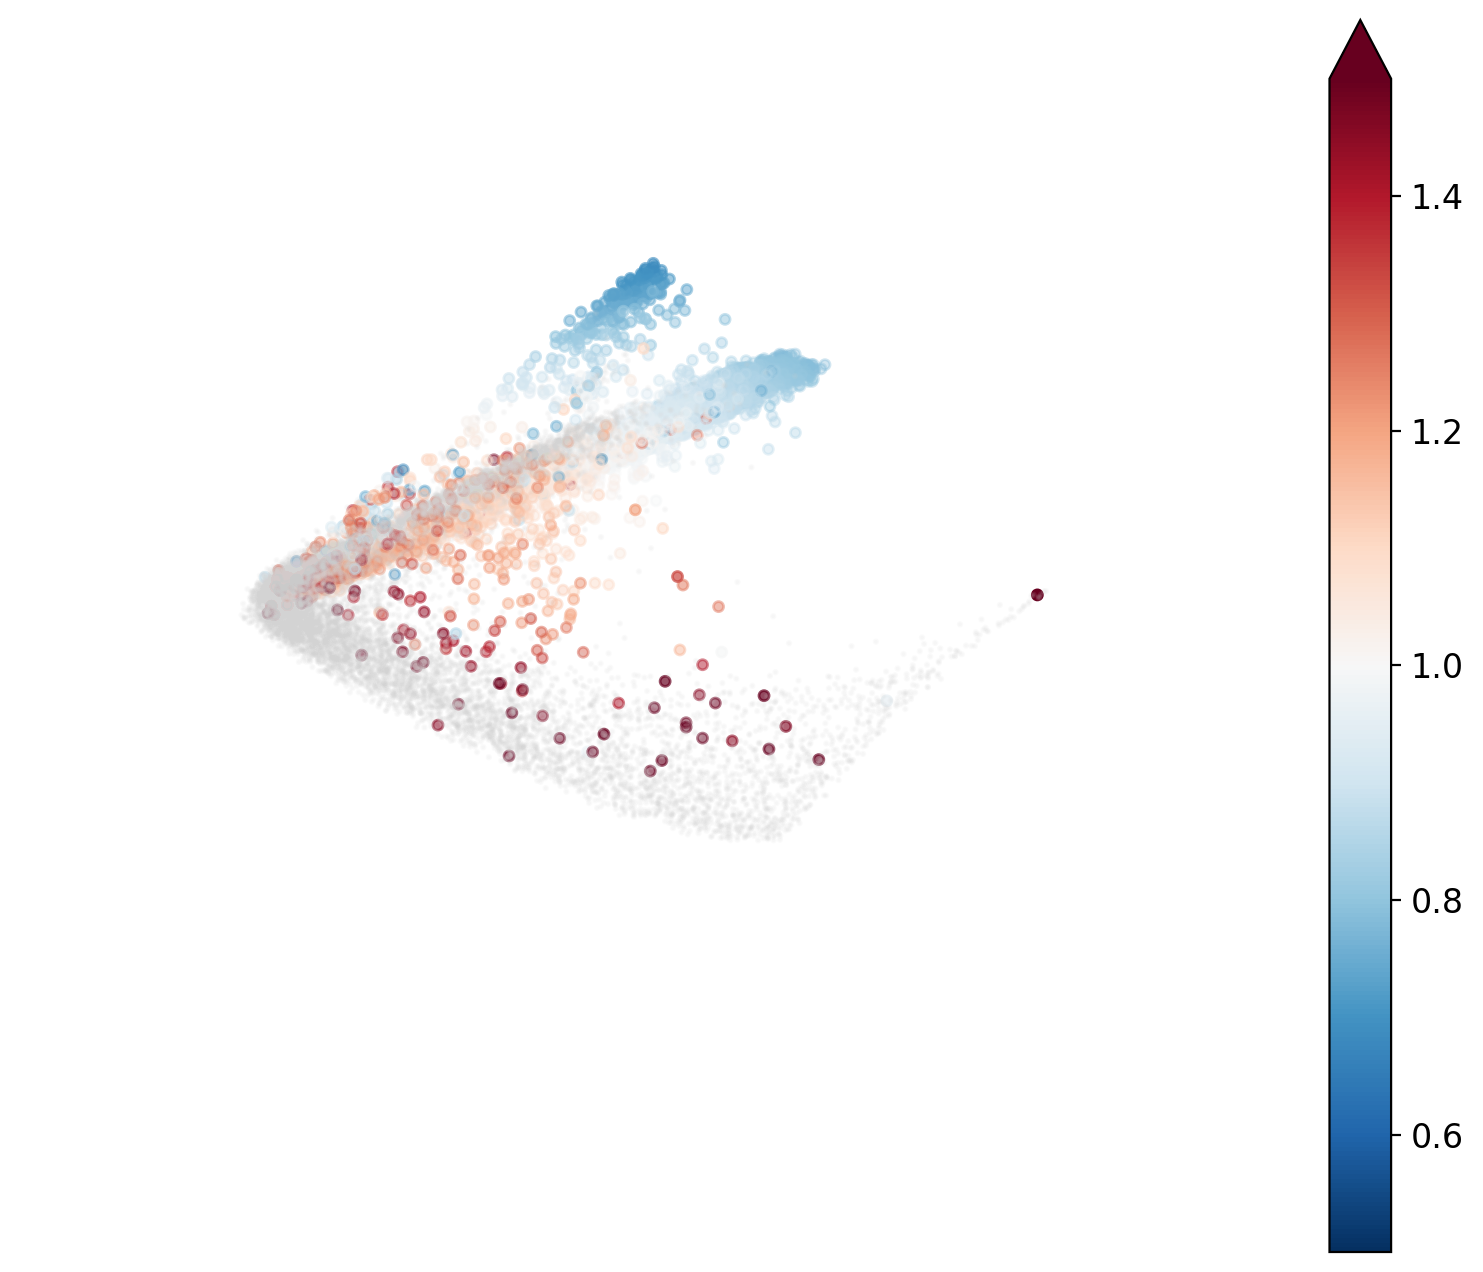

In [112]:
fig = plt.figure(figsize=(10,8), dpi=200)
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(combined_magic_pc_norm, c='lightgray', ax=ax, alpha=0.1, mask=adata_beta.obs.samples != 'WT')
scprep.plot.scatter3d(combined_magic_pc_norm[refined_clust != 4], c=np.load('gcs_5tp_2.npy'), ax=ax, s=13, 
                      mask=adata_beta.obs.samples[refined_clust != 4] == 'WT', vmin=0.5, vmax=1.5, cmap='RdBu_r', ticks=None,
                      azim=-30,elev=50)
ax.axis('off')
fig.savefig('figures/WT_proliferation_score.png', dpi=300)

In [7]:
wt_growth_coeff = pd.DataFrame(np.load('gcs_5tp_2.npy')[adata_beta.obs.samples[refined_clust != 4] == 'WT'], index=adata_beta_wt.obs_names)
wt_growth_coeff['at_comm'] = wt_at_comms

In [8]:
wt_growth_coeff = wt_growth_coeff.sort_values('at_comm')

In [9]:
colors = list(sns.color_palette('Set1', n_colors=4)) + \
list(sns.color_palette('Paired', n_colors=3)) + ['lightgray'] + \
list(sns.color_palette('Set2', n_colors=7).as_hex())
cmap = dict(zip(np.unique(pd.concat((wt_at_comms, hfd_at_comms, obob_at_comms))), colors))

/tmp/ipykernel_2331663/2488600886.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(wt_growth_coeff, x='at_comm', y=0, palette=cmap)
/tmp/ipykernel_2331663/2488600886.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


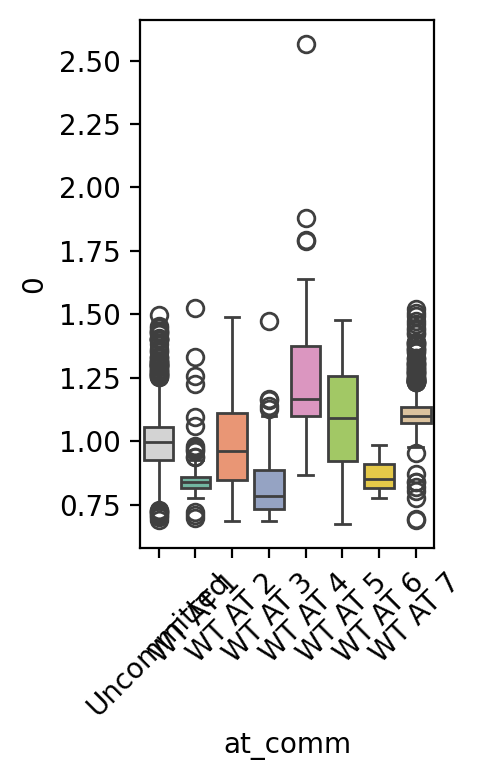

In [10]:
fig, ax = plt.subplots(figsize=(2.5,4), dpi=200)
ax = sns.boxplot(wt_growth_coeff, x='at_comm', y=0, palette=cmap)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
fig.savefig('figures/proliferation_rate_per_at.png')

In [46]:
for at in wt_at_comms.unique():
    print (at)
    print(wt_growth_coeff[wt_at_comms == at].mean())

WT AT 7
0    1.112206
dtype: float64
Uncommitted
0    0.99846
dtype: float64
WT AT 1
0    0.84189
dtype: float64
WT AT 6
0    0.866297
dtype: float64
WT AT 3
0    0.818559
dtype: float64
WT AT 4
0    1.237194
dtype: float64
WT AT 5
0    1.084741
dtype: float64
WT AT 2
0    0.988825
dtype: float64


In [23]:
ats = wt_growth_coeff['at_comm'].unique()

In [29]:
for at in ats:
    print(f'WT AT 4 proliferation > {at} p =', ranksums(wt_growth_coeff[wt_growth_coeff['at_comm'] == 'WT AT 4'][0].tolist(),
                     wt_growth_coeff[wt_growth_coeff['at_comm'] == at][0].tolist(), alternative='greater').pvalue)

WT AT 4 proliferation > Uncommitted p = 1.0737552548109313e-71
WT AT 4 proliferation > WT AT 1 p = 1.2280971946446931e-88
WT AT 4 proliferation > WT AT 2 p = 1.5981076975052817e-21
WT AT 4 proliferation > WT AT 3 p = 2.1394899166674495e-64
WT AT 4 proliferation > WT AT 4 p = 0.5
WT AT 4 proliferation > WT AT 5 p = 4.493308985977649e-08
WT AT 4 proliferation > WT AT 6 p = 1.83234076576793e-46
WT AT 4 proliferation > WT AT 7 p = 5.4766065998374956e-18


In [33]:
wt_magic_pc_norm = pd.read_pickle('../analysis_archetypes/results/WT_magic_pc_norm.pkl')

In [6]:
alphas = [0.01, 0.1, 1, 2, 5, 10]
from scipy.stats import spearmanr
import numpy as np
import seaborn as sns
import pandas as pd
alpha_comparison = pd.DataFrame(index=alphas, columns=alphas)

<Axes: >

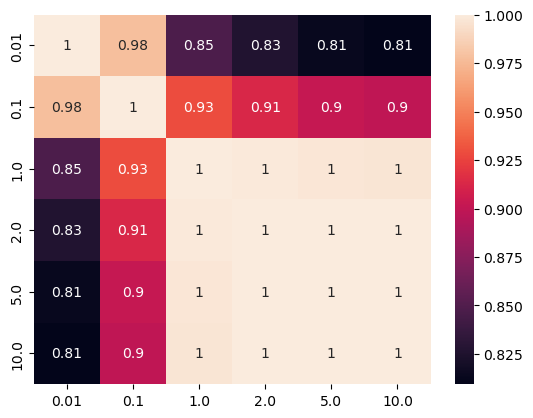

In [14]:
for alpha1 in alphas:
    for alpha2 in alphas:
        alpha_comparison.loc[alpha1][alpha2] = spearmanr(np.load(f'gcs_5tp_{alpha1}.npy'),
                                                         np.load(f'gcs_5tp_{alpha2}.npy')).statistic.astype(float)
sns.heatmap(alpha_comparison, annot=True)